In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer

In [3]:
from sklearn.metrics import classification_report

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# Visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = 'drive/My Drive/data'

In [7]:
try:
    df = pd.read_csv(path+'/13GEN.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(path+'/13GEN.csv', encoding='ISO-8859-1')
print(df.shape)

(778, 6)


SPLITTING DATASET INTO TRAINING DATA AND TESTING DATA

In [8]:
from sklearn.model_selection import train_test_split

# Split the data
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Print the size of the splits
print(f"Training data size: {len(train_data)}")
print(f"Testing data size: {len(test_data)}")

Training data size: 622
Testing data size: 156


In [9]:
train_data.head()

,ID,Name,Stars,Title,Date,Description
694,695.0,Ryan Peck,5,Very good,NaN,A great processer for Blender and gaming. 24 c...
638,639.0,IndyToronto,3,Surprisingly Fast but watch out for corner chi...,NaN,We set up multiple computing servers to run he...
133,134.0,Nifnorts,1,Damaged,NaN,Damaged box and mobo can't read processor. Ret...
355,356.0,Amazon Customer,1,CPU received appears to have been used,NaN,Received relatively quick. The issue was there...
55,56.0,Technopaul,5,Exelent rapport qualitÃ© prix,NaN,Also serves my MSI MPG B760I EDGE WIFI PC Inte...


In [10]:
test_data.head()

,ID,Name,Stars,Title,Date,Description
595,596.0,sergio,1,Imballaggio i9 13900k,NaN,The media could not be loaded.
587,588.0,Amazon Customer,1,"It's junk, don't buy this. It won't boot up my...",NaN,Not even worth throwing away money to buy. Sta...
543,544.0,Wolfgang Werner,5,As described,NaN,I was close to give them a bad review but then...
644,645.0,John M. Macros,4,Faster than expected,NaN,"Havent used intel in a long time, glad I went ..."
487,488.0,Fortnite89,5,Una bella Bombetta,NaN,"Excellent CPU performing, quick I recommend th..."


In [11]:
print(stopwords.words('english'))
emoticons = [":)", ':-)', ': )', ':D', '=)', ':(', ':-(', ': (']
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(emoticons)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Cleaning the data/ Preprocessing

In [12]:
import re # import regex

def preprocess_data(data):
  data = data.drop_duplicates(subset=['Description'], keep='first')

  # Remove emojis from data
  data = data.astype(str).apply(lambda x: x.str.encode('ascii', 'ignore').str.decode('ascii'))

  # Remove emoticons as stopwords so it will happen when tokenizing our sentences hence not needed here

  # Remove urls
  def remove_username_link_nums(Description):
    Description = re.sub('@[^\s]+', '', Description)
    Description = re.sub('http[^\s]+', '',Description)
    Description = re.sub(r'\d+', '', Description)
    return Description

  data['Description'] = data['Description'].apply(remove_username_link_nums)

  # # turn text to lowercase
  data['Description'] = data['Description'].map(lambda x: x.lower())

  # Remove stopwords and lemmatize the text
  lem = WordNetLemmatizer()
  def remove_stopwords(Description):
    tokens = []
    for token in text.split():
      if token not in stpwrd:
        tokens.append(lem.lemmatize(token, "v"))

    return  " ".join(tokens)

  data.Description = data.Description.apply(lambda x: remove_stopwords(x))


  return data

In [13]:
train_neg = train_data[:10000]
train_pos = train_data[1590000:]

In [14]:

test_neg = train_data[10000:12000]
test_pos = train_data[1588000:1590000]

In [15]:
train_neg.shape

(622, 6)

In [16]:
train_examples =pd.concat([train_neg, train_pos])
test_examples =pd.concat([test_neg, test_pos])

In [17]:
train_examples.shape

(622, 6)

In [18]:
test_examples.shape

(0, 6)

In [19]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [20]:
train_data.isna().sum().sort_values()

Name             0
ID               1
Stars            1
Title            1
Description      1
Date           620
dtype: int64

In [21]:
train_examples['Description'] = train_examples['Description'].astype(str).fillna('')

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_examples.Description)

In [23]:
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = ""
training_portion = .8

In [24]:
train_sequences = tokenizer.texts_to_sequences(train_examples.Description)
test_sequences = tokenizer.texts_to_sequences(test_examples.Description)

X_train = pad_sequences(train_sequences, maxlen = max_length, padding = padding_type)

X_test = pad_sequences(test_sequences, maxlen = max_length, padding = padding_type)

In [27]:
word_index = tokenizer.word_index

In [28]:
len(word_index)

4418

In [29]:
X_train.shape

(622, 50)

In [30]:
test_data.head()

,ID,Name,Stars,Title,Date,Description
595,596.0,sergio,1,Imballaggio i9 13900k,NaN,The media could not be loaded.
587,588.0,Amazon Customer,1,"It's junk, don't buy this. It won't boot up my...",NaN,Not even worth throwing away money to buy. Sta...
543,544.0,Wolfgang Werner,5,As described,NaN,I was close to give them a bad review but then...
644,645.0,John M. Macros,4,Faster than expected,NaN,"Havent used intel in a long time, glad I went ..."
487,488.0,Fortnite89,5,Una bella Bombetta,NaN,"Excellent CPU performing, quick I recommend th..."


In [31]:
import pickle
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
import gensim

# WORD2VEC
W2V_SIZE = 228
W2V_WINDOW = 7
W2V_EPOCH = 10
W2V_MIN_COUNT = 10
documents = [text.split() for text in train_examples['Description'].astype(str)]


w2v_model = gensim.models.Word2Vec(vector_size=W2V_SIZE,
                                   window=W2V_WINDOW,
                                   min_count=W2V_MIN_COUNT,
                                   workers=8)
w2v_model.build_vocab(documents)
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(108548, 287350)

In [33]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size:", vocab_size)

Vocab size: 396


In [34]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(108682, 287350)

In [35]:
try:
    similar_words = w2v_model.wv.most_similar("great")
    print("Most similar words to 'great':")
    print(similar_words)
except KeyError:
    print("'great' is not in the vocabulary.")

Most similar words to 'great':
[('performance.', 0.9981948137283325), ('fast', 0.9980400204658508), ('performance,', 0.9980177879333496), ('money.', 0.997850775718689), ('Excellent', 0.9978246688842773), ('Great', 0.9978062510490417), ('Very', 0.9977878928184509), ('choice', 0.9977783560752869), ('perfect', 0.9977499842643738), ('powerful', 0.997712254524231)]


In [36]:
from tensorflow.keras.initializers import Constant

In [37]:
embedding_matrix = np.zeros((vocab_size + 1, W2V_SIZE))  # Add 1 to vocab_size to account for index starting from 1

for word, i in tokenizer.word_index.items():
    if i <= vocab_size:  # Ensure index i is within bounds
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]

print(embedding_matrix.shape)

(397, 228)


# Building our NLP model using LSTM

In [38]:
model_1 = tf.keras.models.Sequential([
                                      tf.keras.layers.Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=max_length, trainable=False),
                                      tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True)),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Bidirectional(LSTM(128)),
                                      tf.keras.layers.Dropout(0.2),
                                      tf.keras.layers.Dense(64, activation='relu'),
                                      tf.keras.layers.Dense(1, activation='sigmoid')

], name='Bidirectional_LSTM_1')

model_1.summary()

Model: "Bidirectional_LSTM_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 228)           90516     
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           365568    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)       

In [39]:
import pandas as pd
from keras.preprocessing.text import Tokenizer

In [40]:
df['Description'] = df['Description'].astype(str).fillna('')

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Description'])

sequences = tokenizer.texts_to_sequences(df['Description'])
print(sequences[:5])

[[470, 182, 599, 48, 7, 369, 15, 119, 78, 11, 5, 252, 749, 3, 294, 4, 666, 53, 231, 155, 2, 6, 439, 18, 749, 7, 294, 4, 143, 512, 1244, 12, 1556, 2, 14, 91, 513, 600, 54, 12, 2329, 308, 37, 857, 1034, 2330, 16, 127, 153, 20, 144, 31, 4, 1245, 6, 5, 1, 1035, 2, 127, 370, 3, 1036, 667, 5, 750, 54, 1, 210, 127, 1246, 72, 94, 71, 183, 2, 61, 127, 858, 1, 11, 10, 3, 350, 55, 6, 211, 2, 1246, 72, 7, 9, 1, 232, 83, 13, 177, 132, 8, 1037, 5, 400, 54, 18, 3, 11, 81, 668, 54, 1557, 34, 194, 39, 40, 13, 859, 2, 4, 860, 159, 351, 14, 11, 31, 1247, 7, 2, 106, 8, 3, 350, 55, 2, 172, 160, 51, 401, 2331, 369, 4, 35, 48, 371, 55, 8, 309, 1038, 4, 861, 32, 1558, 14, 862], [11, 1559, 1560, 17, 14, 168, 471, 402, 169, 95, 669, 8, 128, 5, 2332, 3, 372, 8, 3, 472, 403, 554, 195, 44, 111, 161, 21, 3, 1561, 2, 1562, 1248], [1, 139, 25, 751, 1, 68, 1249, 25, 1250, 1, 11, 50, 116, 12, 1, 140, 1563, 2333, 2334, 17, 6, 1, 752, 153, 20, 182, 162, 39, 555, 139, 133, 5, 1251, 2335, 5, 2336, 4, 22, 5, 473, 6, 352, 21

In [41]:
test_data.dtypes

ID             float64
Name            object
Stars           object
Title           object
Date            object
Description     object
dtype: object

Splitting datasets into training and testing data

In [42]:
df['Description'] = df['Description'].astype(str).str.lower()

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Description'])
sequences = tokenizer.texts_to_sequences(df['Description'])
padded_sequences = pad_sequences(sequences, maxlen=100)

In [43]:
# Prepare labels
df['Stars'] = pd.to_numeric(df['Stars'], errors='coerce')
df = df.dropna(subset=['Stars'])
labels = df['Stars'].astype(int)  # Assuming 'Stars' is your target variable
labels = np.where(labels > 3, 1, 0)

In [44]:
max_sequence_length = 100

X_padded = np.random.rand(100, 50)  # Example X_padded with 100 samples and 50 features
y = np.random.randint(0, 2, size=101)

In [45]:
y = y[:100]
assert len(X_padded) == len(y), "X_padded and y must have the same length"

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

In [48]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')
print(f'Length of y_train: {len(y_train)}')
print(f'Length of y_test: {len(y_test)}')

Length of X_train: 80
Length of X_test: 20
Length of y_train: 80
Length of y_test: 20


In [49]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [50]:
# Define the model

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=100))
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.5))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [51]:
# Compile the model
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_1.summary())

Model: "Bidirectional_LSTM_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 228)           90516     
                                                                 
 bidirectional (Bidirection  (None, 50, 256)           365568    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 256)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)       

In [52]:
# Fit the model
history = model_1.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
3/3 [==============================] - 14s 2s/step - loss: 0.6931 - accuracy: 0.5750 - val_loss: 0.6933 - val_accuracy: 0.4500
Epoch 2/50
3/3 [==============================] - 1s 539ms/step - loss: 0.6930 - accuracy: 0.5750 - val_loss: 0.6933 - val_accuracy: 0.4500
Epoch 3/50
3/3 [==============================] - 1s 347ms/step - loss: 0.6929 - accuracy: 0.5750 - val_loss: 0.6934 - val_accuracy: 0.4500
Epoch 4/50
3/3 [==============================] - 1s 341ms/step - loss: 0.6928 - accuracy: 0.5750 - val_loss: 0.6935 - val_accuracy: 0.4500
Epoch 5/50
3/3 [==============================] - 1s 343ms/step - loss: 0.6927 - accuracy: 0.5750 - val_loss: 0.6935 - val_accuracy: 0.4500
Epoch 6/50
3/3 [==============================] - 1s 347ms/step - loss: 0.6926 - accuracy: 0.5750 - val_loss: 0.6936 - val_accuracy: 0.4500
Epoch 7/50
3/3 [==============================] - 1s 326ms/step - loss: 0.6925 - accuracy: 0.5750 - val_loss: 0.6937 - val_accuracy: 0.4500
Epoch 8/50
3/3 [======

In [54]:
y_pred = model_1.predict(X_test)
y_pred = np.where(y_pred>0.5, 1, 0)

1/1 [==============================] - 2s 2s/step


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.45      1.00      0.62         9
           1       0.00      0.00      0.00        11

    accuracy                           0.45        20
   macro avg       0.23      0.50      0.31        20
weighted avg       0.20      0.45      0.28        20



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
model_1.save('Sentiment_LSTM_model_better.h5')
with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
from keras.models import load_model
model_1 = load_model('Sentiment_LSTM_model_better.h5')
# loading tokenizer
with open('trainHistoryDict', 'rb') as file_pi:
    history = pickle.load(file_pi)

In [58]:
history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

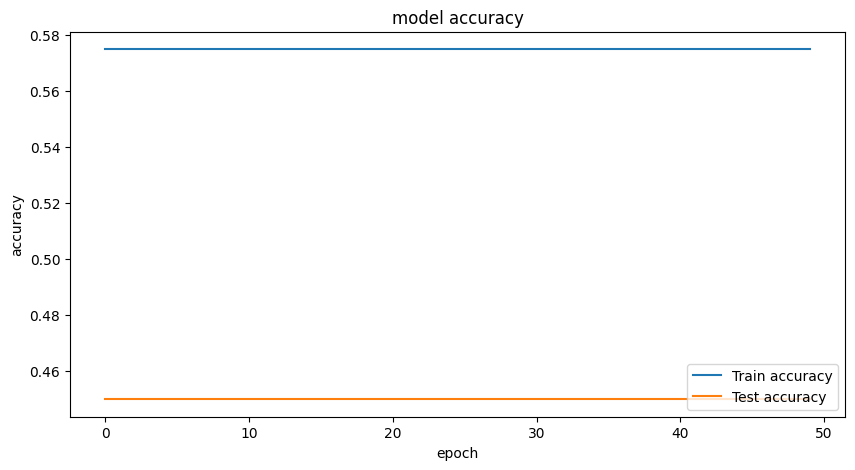

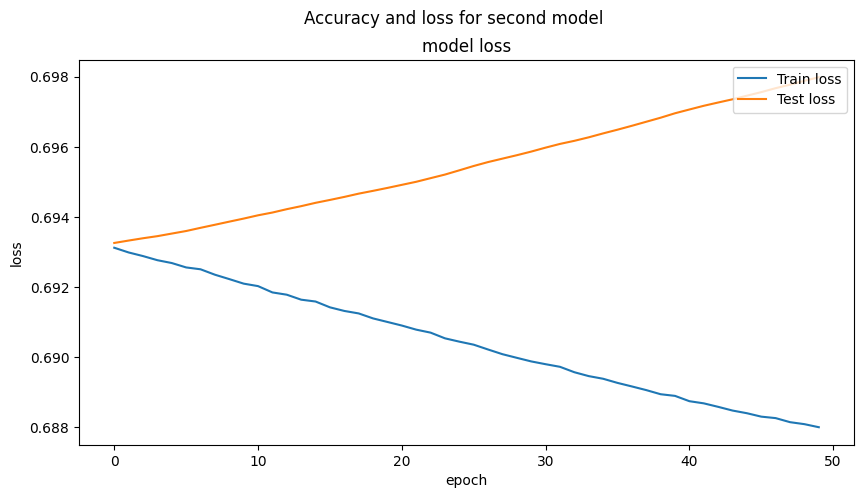

In [59]:
plt.figure(figsize=(10,5))
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train accuracy', 'Test accuracy'], loc='lower right')
plt.show()
# History for loss
plt.figure(figsize=(10,5))
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Test loss'], loc='upper right')
plt.suptitle('Accuracy and loss for second model')
plt.show()

In [60]:
def predict(text):
    try:
        # Tokenize text
        x_test = tokenizer.texts_to_sequences([text])
        x_test = pad_sequences(x_test, maxlen=max_length)

        # Predict
        score = model_1.predict(x_test)[0]

        # Determine label based on score
        if score >= 0.4 and score <= 0.6:
            label = "Neutral"
        elif score < 0.4:
            label = "Negative"
        else:
            label = "Positive"

        return {"label": label,
                "score": float(score)}

    except Exception as e:
        print(f"Error predicting sentiment: {str(e)}")
        return {"label": "Error",
                "score": 0.0}

In [61]:
example = df['Description'][500]
print(example)

very good processor 


In [62]:
predict(example)

1/1 [==============================] - 4s 4s/step


<ipython-input-60-b7716a0edfe7>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "score": float(score)}


{'label': 'Neutral', 'score': 0.48296883702278137}